In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def df_plot_cdf(data, colname, **kwargs):
    df = pd.DataFrame()
    df['counts'] = data.groupby(colname)[colname].count()
    df['cumsum'] = df['counts'].cumsum()
    df['cdf'] = df['cumsum']/float(df['counts'].sum())
    df['cdf'].plot(**kwargs)

# Priority Thread Scheduling

## Static Load

In [15]:
lnic_sched_stats = pd.read_csv('results-workload/2020-08-07--22-45-24-lnic-evaluation/switch0/resp_time.csv')
lnic_sched_stats['resp_time'] /= 3.2e3 # convert to us

In [17]:
timer_sched_stats = pd.read_csv('results-workload/2020-08-07--22-49-02-lnic-evaluation/switch0/resp_time.csv')
timer_sched_stats['resp_time'] /= 3.2e3 # convert to us

In [18]:
lnic_sched_stats.head()

,context,mean_arrival_time,mean_service_time,recv_time,resp_time,sent_time,service_time,time
0,0.0,1600.0,1600.0,108267041.0,0.656563,108264940.0,1600.0,108267040.0
1,1.0,1600.0,1600.0,108267201.0,0.794063,108264660.0,1600.0,108267180.0
2,1.0,1600.0,1600.0,108268832.0,0.866250,108266060.0,1600.0,108268720.0
3,1.0,1600.0,1600.0,108270463.0,1.244687,108266480.0,1600.0,108270400.0
4,1.0,1600.0,1600.0,108272091.0,1.184687,108268300.0,1600.0,108272080.0


<IPython.core.display.Javascript object>


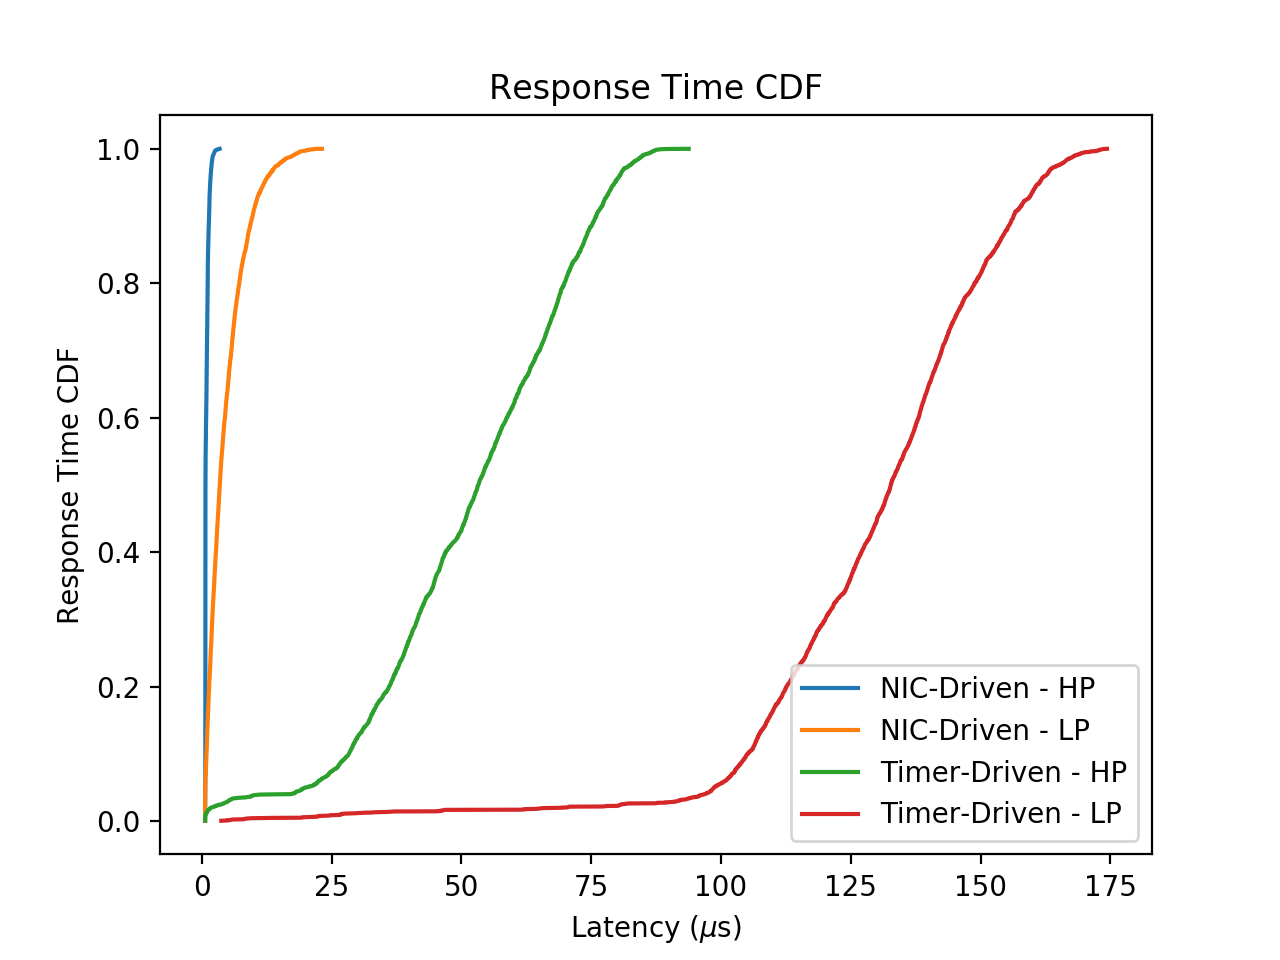

In [19]:
plt.figure()
df_plot_cdf(lnic_sched_stats[lnic_sched_stats['context'] == 0], 'resp_time', label='NIC-Driven - HP')
df_plot_cdf(lnic_sched_stats[lnic_sched_stats['context'] == 1], 'resp_time', label='NIC-Driven - LP')
df_plot_cdf(timer_sched_stats[timer_sched_stats['context'] == 0], 'resp_time', label='Timer-Driven - HP')
df_plot_cdf(timer_sched_stats[timer_sched_stats['context'] == 1], 'resp_time', label='Timer-Driven - LP')
plt.title('Response Time CDF')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

## Load Sweep

In [42]:
def plot_load_cdfs_sched(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data[data['context'] == 0], 'resp_time', label='{}-C0'.format(m))
        df_plot_cdf(data[data['context'] == 1], 'resp_time', label='{}-C1'.format(m))
        print 'Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data))

In [41]:
def process_resp_time_sched(df):
    # compute load
    df['load'] = 1e3/(df['mean_arrival_time']/3.2) # MRPS
    # convert resp_time from cycles to us
    df['resp_time'] /= 3.2e3
    # compute and return tail latency
    # TODO(sibanez): if the number of samples is less than the number of
    #   requests that were sent then need to pad the data with infinite
    #   response times.
    c0_tail = df[df['context'] == 0].groupby('load')['resp_time'].quantile(0.99)
    c1_tail = df[df['context'] == 1].groupby('load')['resp_time'].quantile(0.99)
    return c0_tail, c1_tail

In [28]:
lnic_sched_stats = pd.read_csv('results-workload/2020-08-07--23-00-55-lnic-evaluation/switch0/resp_time.csv')
lnic_sched_tail_c0, lnic_sched_tail_c1 = process_resp_time_sched(lnic_sched_stats)

In [31]:
timer_sched_stats = pd.read_csv('results-workload/2020-08-07--23-25-24-lnic-evaluation/switch0/resp_time.csv')
timer_sched_tail_c0, timer_sched_tail_c1 = process_resp_time_sched(timer_sched_stats)

<IPython.core.display.Javascript object>


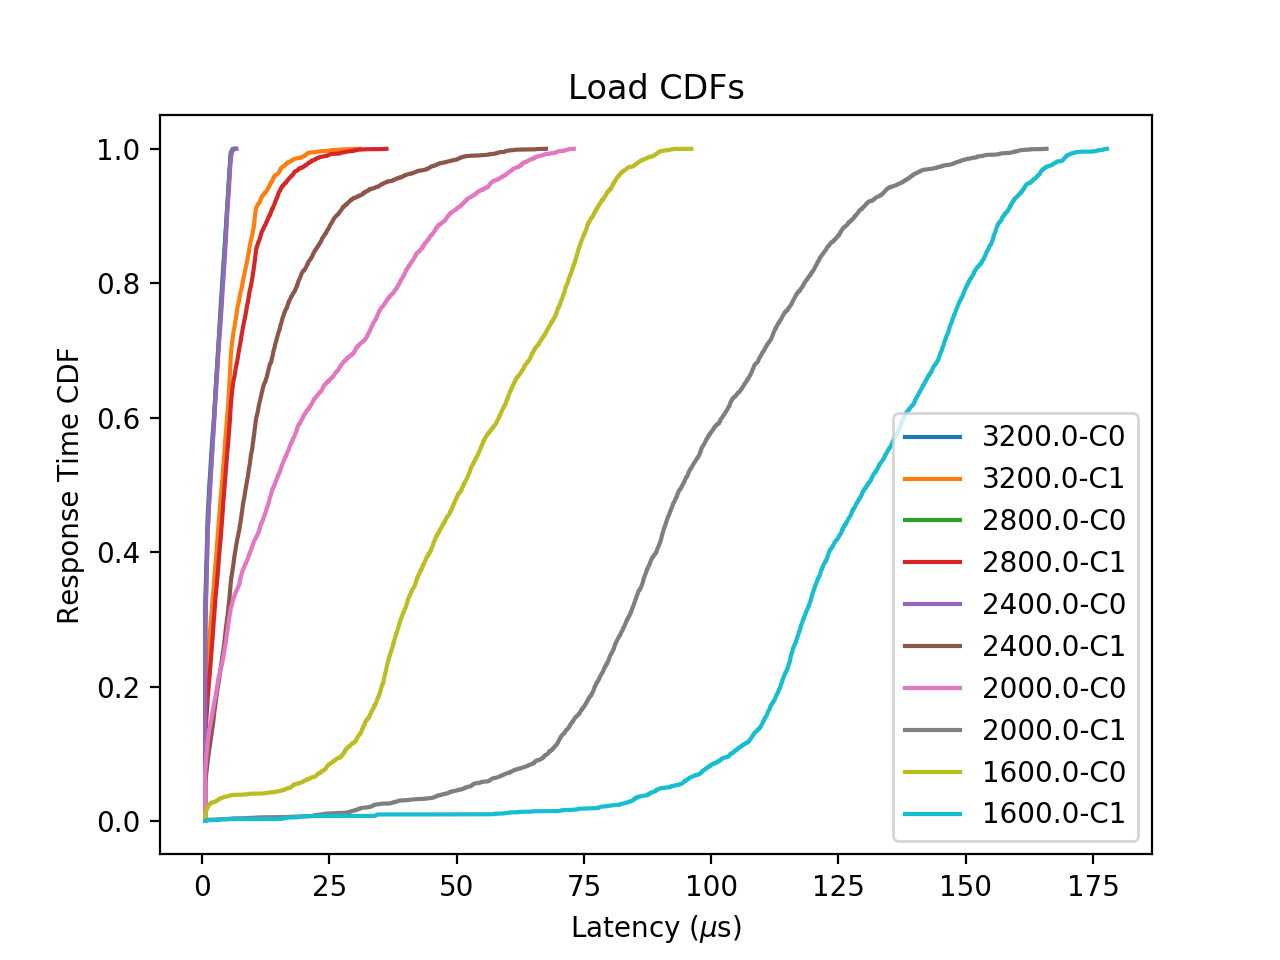

Num Requests @ mean_arrival_time 3200.0 cycles = 10000
Num Requests @ mean_arrival_time 2800.0 cycles = 10000
Num Requests @ mean_arrival_time 2400.0 cycles = 10000
Num Requests @ mean_arrival_time 2000.0 cycles = 10000
Num Requests @ mean_arrival_time 1600.0 cycles = 8308


In [32]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_sched(timer_sched_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


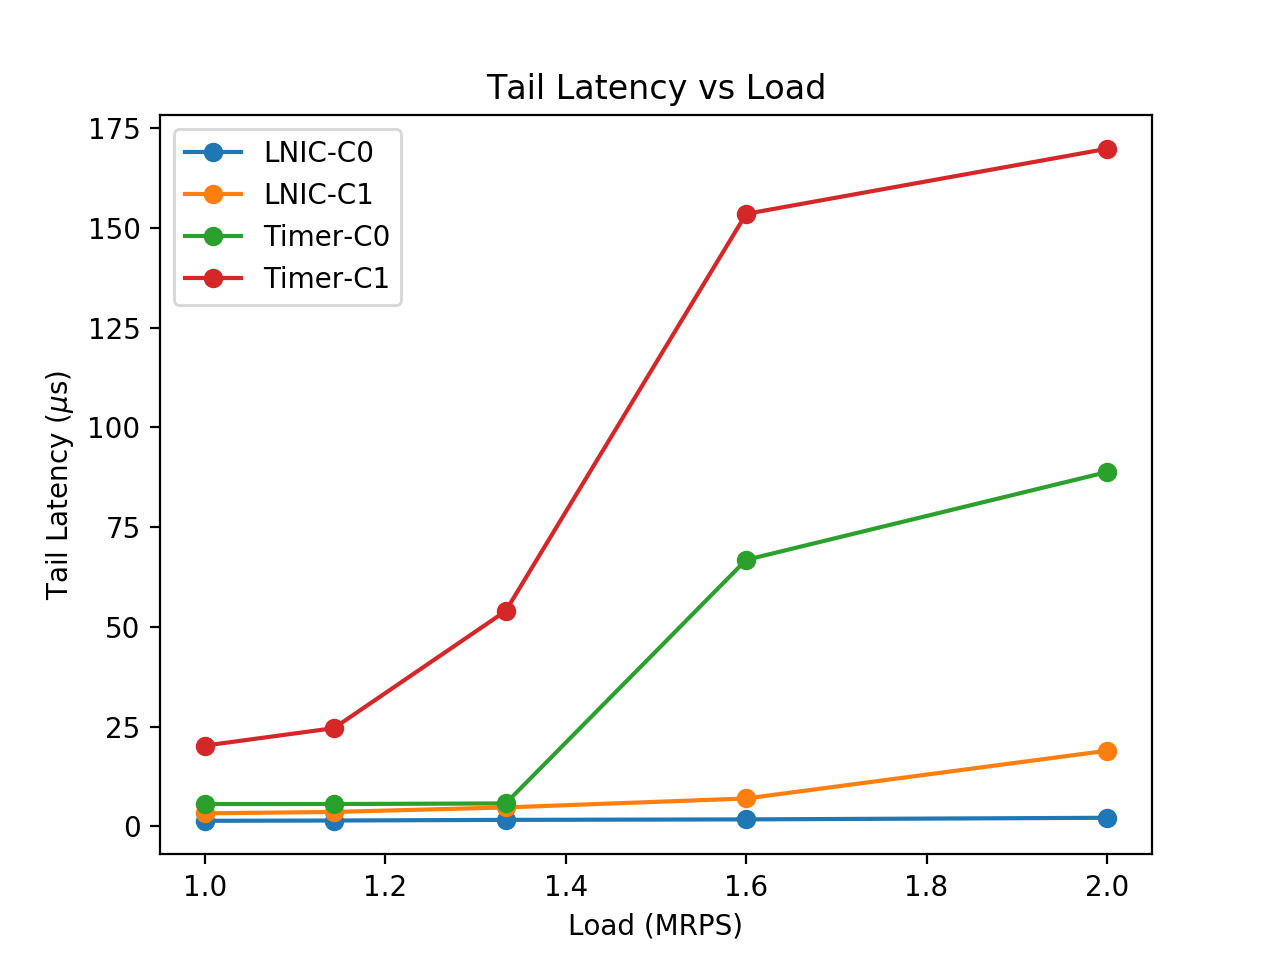

In [39]:
# Plot tail latency vs load
plt.figure()
lnic_sched_tail_c0.plot(marker='o', label='LNIC-C0')
lnic_sched_tail_c1.plot(marker='o', label='LNIC-C1')
timer_sched_tail_c0.plot(marker='o', label='Timer-C0')
timer_sched_tail_c1.plot(marker='o', label='Timer-C1')
plt.title('Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.show()

# Bounded Processing Time

In [48]:
bounded_stats = pd.read_csv('results-workload/2020-08-07--23-41-53-lnic-evaluation/switch0/resp_time.csv')
bounded_tail_c0, bounded_tail_c1 = process_resp_time_sched(bounded_stats)

In [49]:
unbounded_stats = pd.read_csv('results-workload/2020-08-07--23-50-45-lnic-evaluation/switch0/resp_time.csv')
unbounded_tail_c0, unbounded_tail_c1 = process_resp_time_sched(unbounded_stats)

<IPython.core.display.Javascript object>


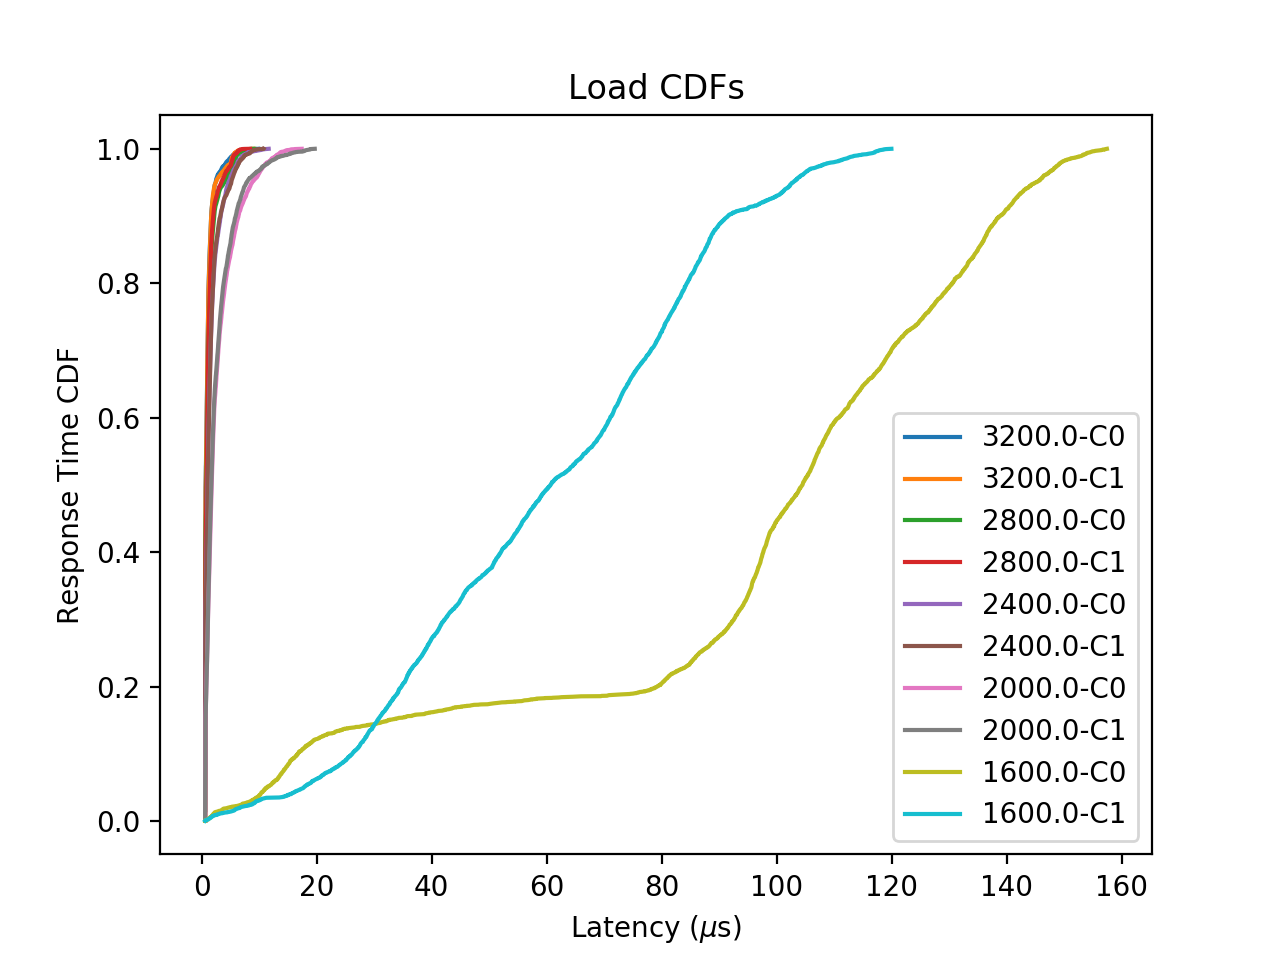

Num Requests @ mean_arrival_time 3200.0 cycles = 10000
Num Requests @ mean_arrival_time 2800.0 cycles = 10000
Num Requests @ mean_arrival_time 2400.0 cycles = 10000
Num Requests @ mean_arrival_time 2000.0 cycles = 10000
Num Requests @ mean_arrival_time 1600.0 cycles = 9261


In [50]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_sched(unbounded_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


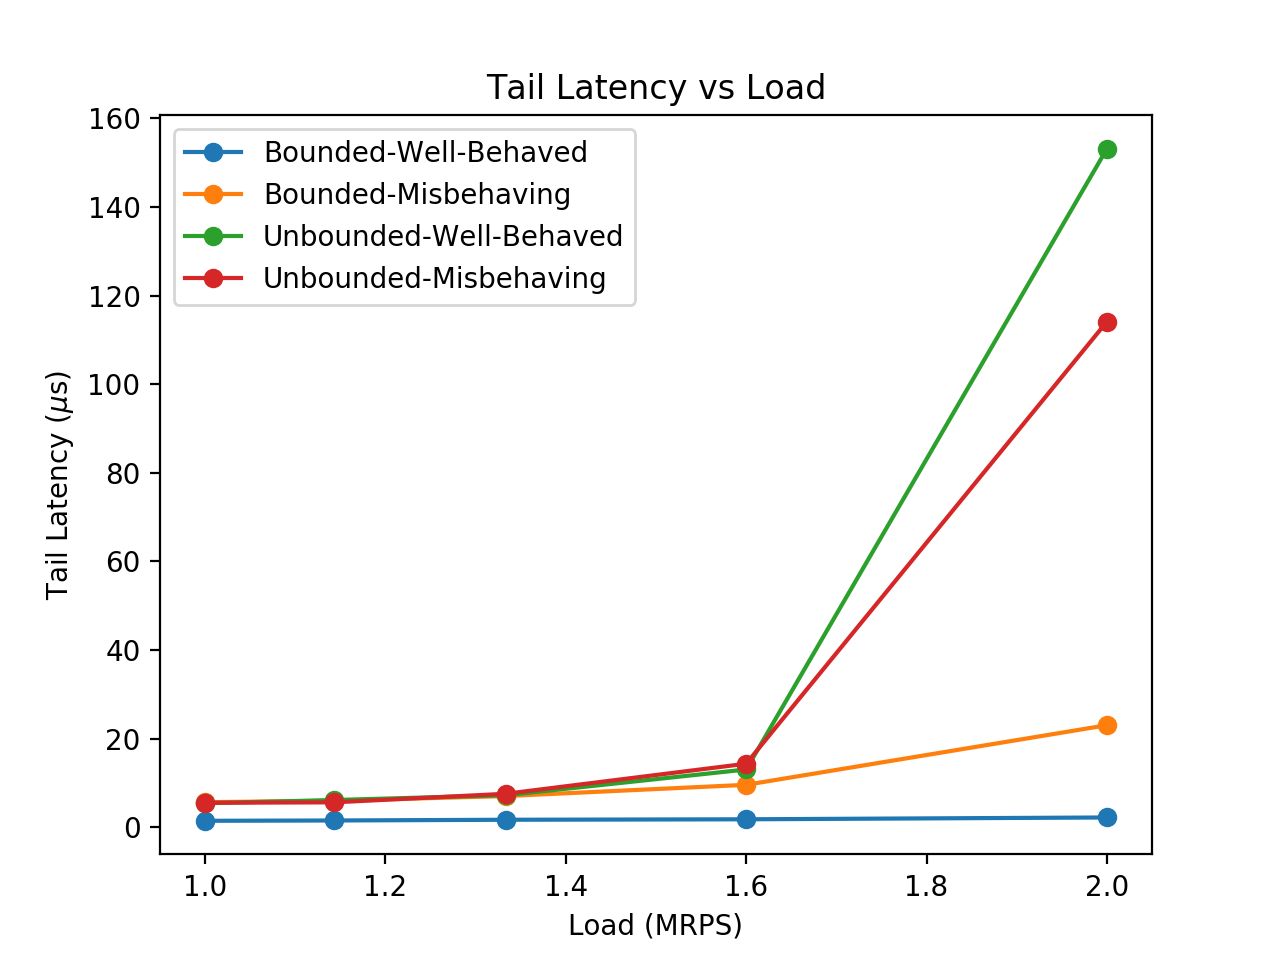

In [51]:
# Plot tail latency vs load
plt.figure()
bounded_tail_c0.plot(marker='o', label='Bounded-Well-Behaved')
bounded_tail_c1.plot(marker='o', label='Bounded-Misbehaving')
unbounded_tail_c0.plot(marker='o', label='Unbounded-Well-Behaved')
unbounded_tail_c1.plot(marker='o', label='Unbounded-Misbehaving')
plt.title('Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.show()

# Load Balancing

In [44]:
def plot_load_cdfs_lb(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data, 'resp_time', label='{}'.format(m))
        print 'Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data))

In [45]:
def process_resp_time_lb(df):
    # compute load
    df['load'] = 1e3/(df['mean_arrival_time']/3.2) # MRPS
    # convert resp_time from cycles to us
    df['resp_time'] /= 3.2e3
    # compute and return tail latency
    # TODO(sibanez): if the number of samples is less than the number of
    #   requests that were sent then need to pad the data with infinite
    #   response times.
    tail = df.groupby('load')['resp_time'].quantile(0.99)
    return tail

In [59]:
rss_stats = pd.read_csv('results-workload/2020-08-08--00-40-06-lnic-evaluation/switch0/resp_time.csv')
rss_tail = process_resp_time_lb(rss_stats)

In [62]:
jbsq_stats = pd.read_csv('results-workload/2020-08-08--00-44-00-lnic-evaluation/switch0/resp_time.csv')
jbsq_tail = process_resp_time_lb(jbsq_stats)

In [65]:
jbsq_pre_stats = pd.read_csv('results-workload/2020-08-08--00-48-38-lnic-evaluation/switch0/resp_time.csv')
jbsq_pre_tail = process_resp_time_lb(jbsq_pre_stats)

<IPython.core.display.Javascript object>


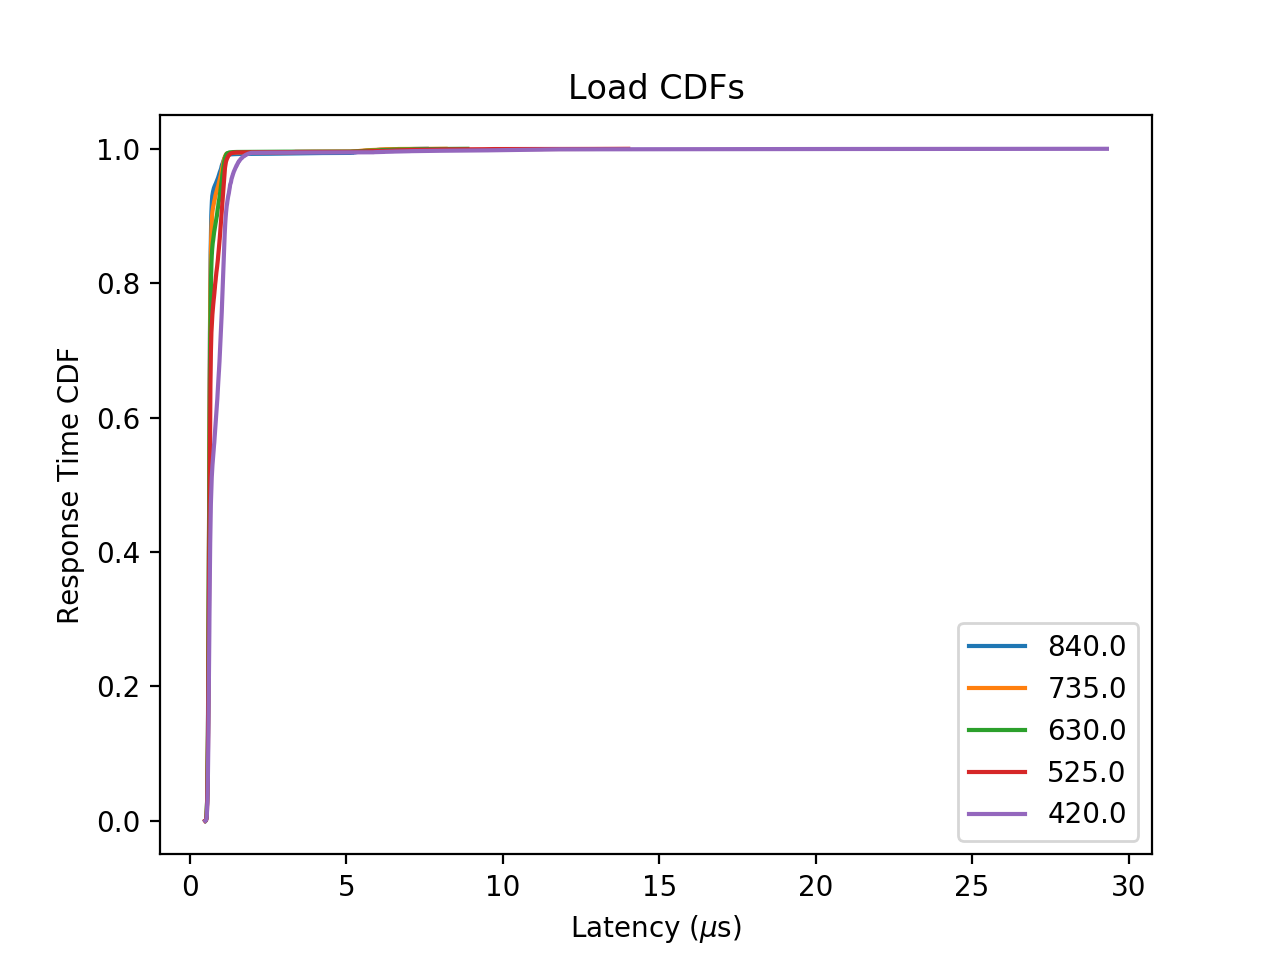

Num Requests @ mean_arrival_time 840.0 cycles = 10000
Num Requests @ mean_arrival_time 735.0 cycles = 10000
Num Requests @ mean_arrival_time 630.0 cycles = 10000
Num Requests @ mean_arrival_time 525.0 cycles = 10000
Num Requests @ mean_arrival_time 420.0 cycles = 10001


In [66]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_lb(jbsq_pre_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


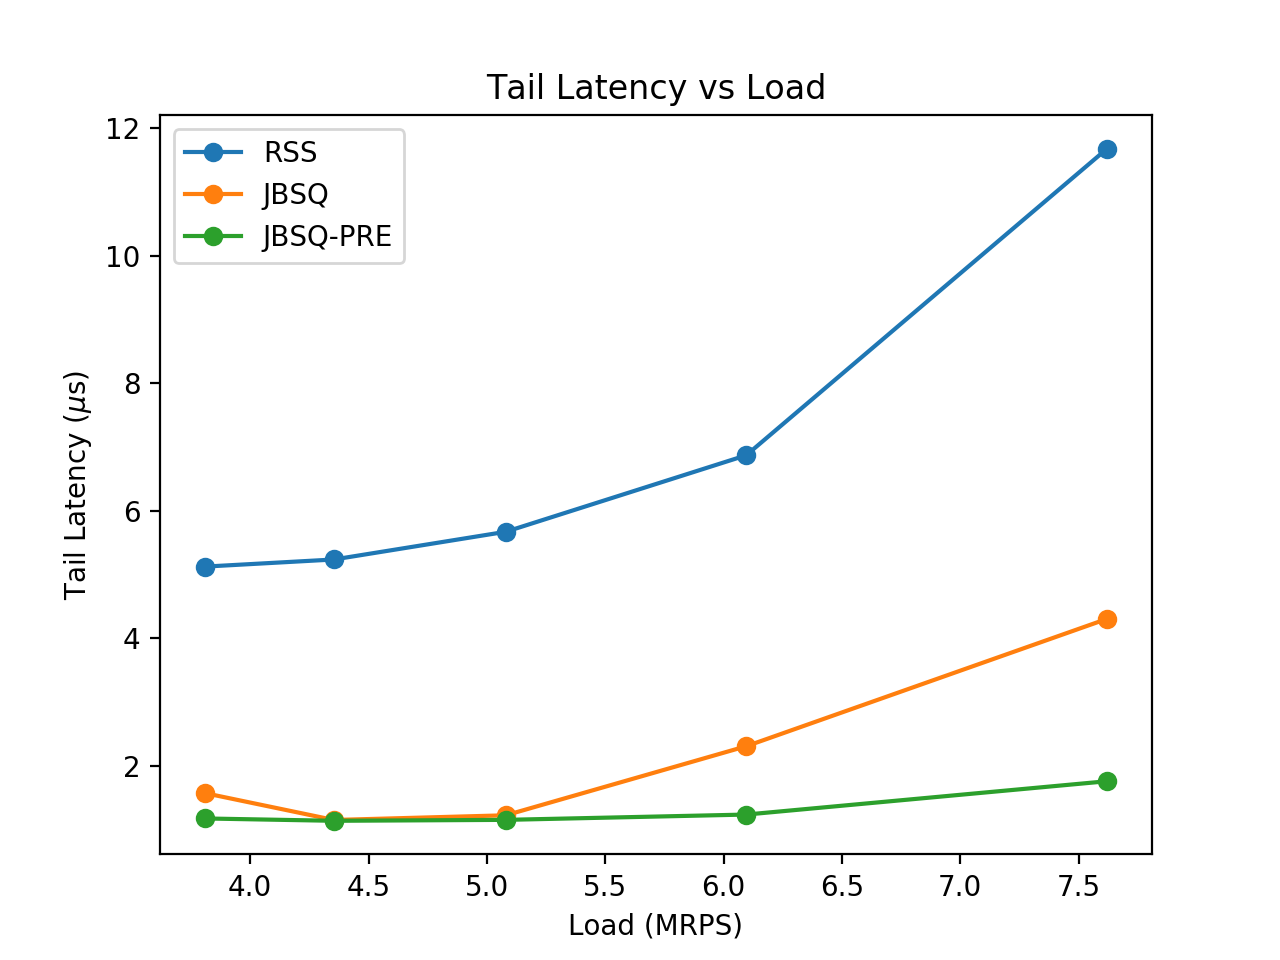

In [67]:
# Plot tail latency vs load
plt.figure()
rss_tail.plot(marker='o', label='RSS')
jbsq_tail.plot(marker='o', label='JBSQ')
jbsq_pre_tail.plot(marker='o', label='JBSQ-PRE')
plt.title('Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.show()